In [1]:
import os
import numpy as np
from numpy.linalg import eigvalsh
import math
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, kron
from itertools import product, combinations
import plotly.graph_objects as go
from scipy.linalg import expm, sinm, cosm

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})  # Change 12 to the desired font size
# Enable LaTeX rendering in Matplotlib
plt.rc('text', usetex=True)
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

np.set_printoptions(edgeitems=10)  # Set the number of elements at the beginning and end of each dimension when repr is called
np.set_printoptions(threshold=1000)  # Set the total number of array elements which trigger summarization rather than full repr
np.set_printoptions(precision=4)  # Set the precision for floating point output

ar = np.array
kr = np.kron
T = np.transpose

<h1>This notebook has an MSD function working based on mutual informatino, tested on a 1D ising model, as well as some Hamiltonians reconstructed from the couplings.<h1>

We start with all the functions necessary to MDS.

In [2]:
paulis = [np.eye(2), np.array([[0,1],[1,0]]), 1j*np.array([[0,-1],[1,0]]), np.array([[1,0],[0,-1]])]
paulis_sparse = [coo_matrix(p, dtype='complex128') for p in paulis]

def operator_from_indexes(indexes, dtype='float64'):
    """
    indexes : list of pauli string indexes (eg [0,1,2,0,3])
    return : coo_matrix representing a pauli string (eg 1XY1Z)
    """
    op = paulis_sparse[indexes[0]]
    for i in indexes[1:]:
        op = kron(op, paulis_sparse[i], format='coo')
    if dtype=='float64':
        op = op.real
    return coo_matrix(op, dtype=dtype)


def Hab(Jab, a, b):
    """
    return the hamiltonian corresponding to a particular interraction type, eg XZ:
    sum_ij Jabij sigma_i^b sigma_j^a
    Jab : matrix of couplings
    a: interraction type
    b: interraction type
    It fill up H by doing the following: takes 2 pauli indices to determine the intertaction type and also takes the relevant coupling table.
    It loops over all possible 2-pauli strings with these 2 indices, for ex xz111111,, x1z111111, ..., 111x111z111,.... 
    For each of these the corresponding matrix is constructed I guess in the Pauli-z basis since this is the basis in which the paulis are initialy defined.
    For each of theses operators we add it to the hamiltonian with its coupling factor.
    To conclude, we get the Hamiltonian defined in the Pauli-z basis
    """
    N = len(Jab)
    H = np.zeros((2**N, 2**N))
    for i, j in list(combinations(range(N), 2)):
        pauli_indexes = np.zeros(N, dtype=int)
        pauli_indexes[i] = a
        pauli_indexes[j] = b
        tau = operator_from_indexes(pauli_indexes)
        H[tau.row, tau.col] += Jab[i,j]*tau.data
    return H

def H_from_couplings(N, k):
    """
    return a dense hamiltonian from the saved couplings. In the Pauli-z basis.
    N: system size
    k: sample number
    """
    letters = ['1', 'X', 'Y', 'Z']
    H = 0
    for a,b in [(1,3),(1,1),(2,2),(3,3),(3,1)]:
        Jab = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b]))
        H += Hab(Jab, a, b)
    return H

def get_eigenstates(H):
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    idx = np.argsort(eigenvalues)[::-1]  # Get the indices for sorting in descending order
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors

def get_full_density_matrix(state):
    """
    Calculate the full density matrix from a given quantum state.
    """
    full_density_matrix = np.outer(state, np.conj(state))
    return full_density_matrix

def partial_ij(state, i,j,N=12):
    kr = np.kron
    ar=np.array
    T=np.transpose
    
    if i == j:
        raise ValueError("The 2 indices cannot be the same")
    
    rho = get_full_density_matrix(state)
    indices = (i, j) if i <= j else (j, i) 
    i = indices[0]
    j = indices[1] # simply redefine i as the lowest index and j as the highest one.

    if j > N-1:
        raise ValueError("Index out of range")
    

    nb_id1=i
    nb_id2=j-i-1
    nb_id3=N-j-1 #note these have to take into account that we start the indices at 0 but N is 12 not 11.
    
    #We will do the operation in 3 partial traces. 
    basis_vectors_1 = [[1 if i == j else 0 for j in range(2**nb_id1)] for i in range(2**nb_id1)] #Basis vectors of the subsystems to the left of i.
    basis_vectors_2 = [[1 if i == j else 0 for j in range(2**nb_id2)] for i in range(2**nb_id2)] # basis vectors of the section between i and j
    basis_vectors_3 = [[1 if i == j else 0 for j in range(2**nb_id3)] for i in range(2**nb_id3)] #basis vectors of the section to the right of j
    
    #We first partial trace over the first section so I need an identity matrix that does'nt touch over all but the first section.
    id = np.array([[1,0],[0,1]])
    right = N-i
    id_after_i = np.identity(2**(right)) #the i matrix that leaves all after i unafected.
    id_after_j = np.identity(2**(N-j-1)) #the matrix that leaves all after and including j unaffected
    id_after_j_plus = np.identity(2**(N-j)) #the matrix that leaves all after and including j unaffected
    #print(f"initial state is {rho.shape}")
    if i !=0:
        rho_0=np.zeros((2**(N-i),2**(N-i)))
        for b in basis_vectors_1:
            O=kr(b, id_after_i)
            rho_0+=O@rho@T(O)
        #print(f"Post first trace it is {rho_0.shape}")
    else: 
        rho_0=rho

    # One partial trace done, we now have rho_1 a matrix with 2^{i rank less}
    if j!=(i+1):
        rho_1=np.zeros((2**(N-j+1),2**(N-j+1)))
        #print(f"b is {basis_vectors_2[0]}")
        for b in basis_vectors_2:
            O=kr(kr(id, b), id_after_j_plus)
            #print(f"O is {O.shape}")
            rho_1+=O@rho_0@T(O)
        #print(f"Post second trace it is {rho_1.shape}")
    else:
        rho_1=rho_0

    # two partial traces done, we finish off by tracing the right part.
    rho_2=np.zeros((2**(2),2**(2)))
    id_2=np.identity(2**2)
    if j!=(N-1):
        for b in basis_vectors_3:
            O=kr(id_2,b)
            rho_2+=O@rho_1@T(O)
        #print(f"Final shape is {rho_2.shape}")
    else:
        rho_2=rho_1
    return rho_2

def partial_ij_from_rho(rho, i,j,N=12):
    kr = np.kron
    ar=np.array
    T=np.transpose
    
    if i == j:
        raise ValueError("The 2 indices cannot be the same")
    
    indices = (i, j) if i <= j else (j, i) 
    i = indices[0]
    j = indices[1] # simply redefine i as the lowest index and j as the highest one.

    if j > N-1:
        raise ValueError("Index out of range")

    nb_id1=i
    nb_id2=j-i-1
    nb_id3=N-j-1 #note these have to take into account that we start the indices at 0 but N is 12 not 11.
    
    #We will do the operation in 3 partial traces. 
    basis_vectors_1 = [[1 if i == j else 0 for j in range(2**nb_id1)] for i in range(2**nb_id1)] #Basis vectors of the subsystems to the left of i.
    basis_vectors_2 = [[1 if i == j else 0 for j in range(2**nb_id2)] for i in range(2**nb_id2)] # basis vectors of the section between i and j
    basis_vectors_3 = [[1 if i == j else 0 for j in range(2**nb_id3)] for i in range(2**nb_id3)] #basis vectors of the section to the right of j
    
    #We first partial trace over the first section so I need an identity matrix that does'nt touch over all but the first section.
    id = np.identity(2)
    right = N-i
    id_after_i = np.identity(2**(right)) #the i matrix that leaves all after i unafected.
    id_after_j = np.identity(2**(N-j-1)) #the matrix that leaves all after and including j unaffected
    id_after_j_plus = np.identity(2**(N-j)) #the matrix that leaves all after and including j unaffected
    #print(f"initial state is {rho.shape}")
    if i !=0:
        rho_0=np.zeros((2**(N-i),2**(N-i)),dtype=complex)
        for b in basis_vectors_1:
            O=kr(b, id_after_i)
            rho_0+=O@rho@T(O)
        #print(f"Post first trace it is {rho_0.shape}")
    else: 
        rho_0=rho

    # One partial trace done, we now have rho_1 a matrix with 2^{i rank less}
    if j!=(i+1):
        rho_1=np.zeros((2**(N-j+1),2**(N-j+1)),dtype=complex)
        #print(f"b is {basis_vectors_2[0]}")
        for b in basis_vectors_2:
            O=kr(kr(id, b), id_after_j_plus)
            #print(f"O is {O.shape}")
            rho_1+=O@rho_0@T(O)
        #print(f"Post second trace it is {rho_1.shape}")
    else:
        rho_1=rho_0

    # two partial traces done, we finish off by tracing the right part.
    rho_2=np.zeros((2**(2),2**(2)),dtype=complex)
    id_2=np.identity(2**2)
    if j!=(N-1):
        for b in basis_vectors_3:
            O=kr(id_2,b)
            rho_2+=O@rho_1@T(O)
        #print(f"Final shape is {rho_2.shape}")
    else:
        rho_2=rho_1
    return rho_2

def get_state(v):
    return v/np.linalg.norm(v)


def VN_entrop(rho):
    #This function takes 4x4 density matrices.
    #calculate the partial trace, and then its entropy.
    eig0=ar([1,0])
    eig1=ar([0,1])
    id = ar([[1,0],[0,1]])
    B0=np.kron(eig0,id)
    B1=np.kron(eig1,id)

    rho_p=B0@rho@T(B0)+B1@rho@T(B1)
    #we diagonalize rho_p
    e,v=np.linalg.eigh(rho_p)
    S=0
    for val in e:
        if val==0:
            S+=0
        else:
            S+=-val*np.log(val)
    #S = -np.trace(rho_p*np.log(rho_p))
    return S

def VN_simple(rho):
    e,v=np.linalg.eigh(rho)
    S=0
    for val in e:
        if val==0:
            S+=0
        else:
            S+=-val*np.log(val)
    #S = -np.trace(rho_p*np.log(rho_p))
    return S

def mutual_info_approx(rho):
    eig0=ar([1,0])
    eig1=ar([0,1])
    id = ar([[1,0],[0,1]])
    
    A0=np.kron(id,eig0)
    A1=np.kron(id,eig1)

    B0=np.kron(eig0,id)
    B1=np.kron(eig1,id)

    rho_1=A0@rho@T(A0)+A1@rho@T(A1)
    rho_2=B0@rho@T(B0)+B1@rho@T(B1)

    rho_12=kr(rho_1,rho_2)
    #print(rho)
    #print(rho_12)
    pauli_z=np.array([[1,0],[0,-1]])
    pauli_zz=np.kron(pauli_z,pauli_z)
    
    I_2 = np.trace((rho-rho_12)@pauli_zz)**2
    I_2= np.real(I_2).astype(float)
    return I_2

def mutual_info(rho):
    #We take the denisty matrix of both substems rho_ij.
    #S(ra)+S(rb)-S(rab)
    eig0=ar([1,0])
    eig1=ar([0,1])
    id = ar([[1,0],[0,1]])
    
    A0=np.kron(id,eig0)
    A1=np.kron(id,eig1)

    B0=np.kron(eig0,id)
    B1=np.kron(eig1,id)

    rho_a=A0@rho@T(A0)+A1@rho@T(A1)
    rho_b=B0@rho@T(B0)+B1@rho@T(B1)
    
    Sa=VN_simple(rho_a)
    Sb=VN_simple(rho_b)
    Sab=VN_simple(rho)
    I = abs(Sa+Sb-Sab)

    return I


def correlation(rho):

    pauli_zz=np.kron(pauli_z,pauli_z)
    
    C = np.trace((rho)@pauli_zz)**2
    return C

def get_S_matrix(N,state):
    S=np.zeros((N,N))
    N=12
    for i in range(N):
        for j in range(i+1,N):
            #To compute the entropy between subsystem i and subsystem j I need to construct their respective density matrices. I need to partial trace everything but i and j. how do I do that?
            rho=partial_ij(state, i, j, N)
            S[i][j]=mutual_info_approx(rho)
            S[j][i]=S[i][j]
            print(f"done for {i},{j}")
    return S

def get_real_I_matrix(N,rho_full):
    I=np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            #To compute the entropy between subsystem i and subsystem j I need to construct their respective density matrices. I need to partial trace everything but i and j. how do I do that?
            rho=partial_ij_from_rho(rho_full, i, j, N)
            I[i][j]=mutual_info(rho)
            I[j][i]=I[i][j]
            print(f"done for {i},{j}")
        min=np.min(I+np.eye(N))
    temp = (N,N)
    ones=np.ones(temp)-np.eye(N)
    if min==0:
        I_eps=0.000001*ones
        I=I+I_eps
    else:
        I=I+min*ones
    return I

def get_I_matrix(N,rho_full):
    I=np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            #To compute the entropy between subsystem i and subsystem j I need to construct their respective density matrices. I need to partial trace everything but i and j. how do I do that?
            rho=partial_ij_from_rho(rho_full, i, j, N)
            I[i][j]=mutual_info_approx(rho)
            I[j][i]=I[i][j]
            print(f"done for {i},{j}")
        min=np.min(I+np.eye(N))
    temp = (N,N)
    ones=np.ones(temp)-np.eye(N)
    if min==0:
        I_eps=0.000001*ones
        I=I+I_eps
    else:
        I=I+min*ones
    return I

def get_correl_matrix(N,rho_full):
    C=np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            #To compute the entropy between subsystem i and subsystem j I need to construct their respective density matrices. I need to partial trace everything but i and j. how do I do that?
            rho=partial_ij_from_rho(rho_full, i, j, N)
            C[i][j]=correlation(rho)
            C[j][i]=C[i][j]
            print(f"done for {i},{j}")
        min=np.min(C+np.eye(N))
    temp = (N,N)
    ones=np.ones(temp)-np.eye(N)
    if min==0:
        I_eps=0.000001*ones
        C=C+I_eps
    else:
        C=C+min*ones

    return C

def define_graph(Jab):
    # Create a graph from Jab
    G = nx.from_numpy_array(Jab)

    edge_colors = [float(e[2]['weight']) for e in G.edges(data=True)]
    cmap = plt.cm.plasma  # You can choose any colormap you prefer

    # Create figure and axes
    fig, ax = plt.subplots()

    # Draw the graph with edge colors based on weight
    nx.draw(G, with_labels=True, edge_cmap=cmap, edge_color=edge_colors, edge_vmin=min(edge_colors), edge_vmax=max(edge_colors), ax=ax)

    # Create colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    fig.colorbar(sm, cax=cbar_ax, label='Edge Weight')
    plt.show()

def re_weighing(I):
    #Define the matrix w which has weights such that closer points have lower weight.
    N=I.shape[0]
    I_0=np.max(I)
    I=I/I_0
    w=np.zeros((N,N))
    for i in range(0,N):
        for j in range(i+1,N):
            #w[i,j]=1/((Jab[i,j]+1e-6))^2
            w[i,j]=-np.log(I[i,j]) 
            w[j,i]=w[i,j]
    return w

def find_all_paths(w, start_vertex, end_vertex, l, path=[]):
    path = path + [start_vertex]
    if start_vertex == end_vertex or len(path) == l:
        if path[-1] == end_vertex:  # Only consider paths that end at the end_vertex
            return [(path)] #return [(path, weight)]
        else:
            return []
    paths = []
    for node in range(w.shape[0]):
        if node not in path:
            newpaths = find_all_paths(w, node, end_vertex, l, path)
            for newpath in newpaths:
                paths.append(newpath)
    
    return paths

def calculate_path_weight(w, path):
    total_weight = 0
    for i in range(len(path) - 1):
        start_vertex = path[i]
        end_vertex = path[i+1]
        total_weight += w[start_vertex][end_vertex]
    return total_weight

def distance(w):
    N=w.shape[0]
    dab=np.zeros((N,N))    
    for a in range(N):
        for b in range(a+1,N):
            weights = [calculate_path_weight(w, path) for path in find_all_paths(w, a, b, 5)]
            dab[a][b]=min(weights)
            dab[b][a]=dab[a][b]
    return dab

def calculate_B(dab):
    N = len(dab)
    B = [[0 for _ in range(N)] for _ in range(N)]
    
    for p in range(N):
        for q in range(N):
            if p == q:
                continue
            d_pq = dab[p][q]
            d_p_sum = sum([dab[p][l]**2 for l in range(N)])
            d_q_sum = sum([dab[l][q]**2 for l in range(N)])
            d_sum = sum([dab[l][m]**2 for l in range(N) for m in range(N)])
            B[p][q] = -0.5 * (d_pq**2 - (d_p_sum + d_q_sum) / N + d_sum / (N**2))
    return B

def calculate_X(B):
    N = np.shape(B)[0]
    X = np.zeros((N, N))

    eigenvalues, eigenvectors = np.linalg.eig(B)
    #TODO should I keep the negative eigenvalues?
    eigenvalues=abs(eigenvalues)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    for i in range(N):
        X[:, i] = np.sqrt(eigenvalues[i]) * eigenvectors[:, i]
    return X

def get_eigenvalues(B):
    eigenvalues, _ = np.linalg.eig(B)
    eigenvalues=abs(eigenvalues)
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    return eigenvalues

def get_X_D(X,D):
    #We defined here X but only with the first D columns.
    N=np.shape(X)[0]
    if D > N:
        raise ValueError("D exceeds the number of columns in X.")
    X_D = X[:, :D]
    return X_D

def euclidean_distance(X):
    N, D = X.shape
    d_e = np.zeros((N, N))

    for p in range(N):
        for q in range(p+1, N):
            diff = X[p] - X[q]
            d_e[p, q] = np.sqrt(np.sum(diff**2))
            d_e[q, p] = d_e[p, q]
    return d_e


def epsilon(D,eig):
    epsilon = 1-np.sum(abs(eig[:D]))/np.sum(abs(eig))
    return epsilon

def plot_3D_points(X):
    X_3=get_X_D(X,3)
    fig = go.Figure(data=go.Scatter3d(x=X_3[:, 0], y=X_3[:, 1], z=X_3[:, 2], mode='markers'))
    fig.update_layout(title='3D Plot of Points', scene=dict(xaxis=dict(title='X-axis'),
                                                         yaxis=dict(title='Y-axis'),
                                                         zaxis=dict(title='Z-axis')))
    fig.show()



We construct a superposition of bell states on the chain and get that ptrace from qutip and home-made give me the same thing!

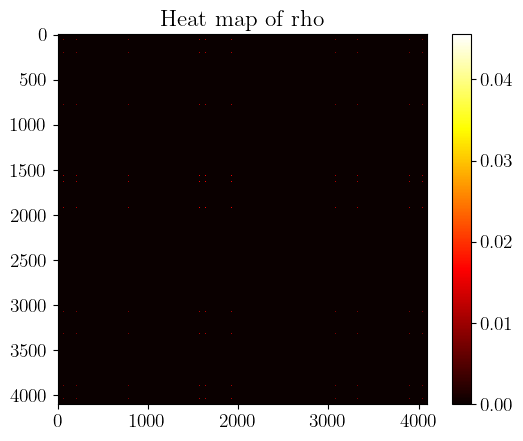

In [54]:
#We create an interesting Hamilotnian to study.
N=12
pauli_z=paulis[3]
pauli_y=paulis[2]
pauli_x=paulis[1]
id=np.identity(2)
Hadamar=1/np.sqrt(2)*ar([[1,1],[1,-1]])
CNOT=ar([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
zero_state=ar([1,0])
#state= [1] + [0] * (2**N-1)
state=zero_state
sup_state=Hadamar@zero_state
bell_state = CNOT@kr(sup_state,zero_state)
#for i in range(N):
#    state=state
#full_state=np.zeros((2**N,2**N), dtype=complex)
full_state_list=[bell_state]
for i in range(int(N/2)-1):
    temp=kr(full_state_list[-1],bell_state)
    full_state_list.append(temp)

Bell1=full_state_list[-1]
Bell2=kr(kr(kr(kr(kr(kr(zero_state,bell_state),bell_state),bell_state),bell_state),bell_state),zero_state)
#side =np.identity(2**(N-1))
#Had1_extended = np.kron(Hadamar,side)
#middle =np.identity(2**(N-2))
#P0=ar([[1,0],[0,0]])
#P1=ar([[0,0],[0,1]])
#CNOT_boundary=kr(kr(P0,middle),id)+kr(kr(P1,middle),pauli_x)
#Bell2=Had1_extended@Bell2
#Bell2=CNOT_boundary@Bell2
state=1/np.sqrt(2)*(Bell1+Bell2)
rho=get_full_density_matrix(state)
plt.imshow(rho, cmap='hot', interpolation='nearest')
plt.title("Heat map of rho")
plt.colorbar()
plt.show()


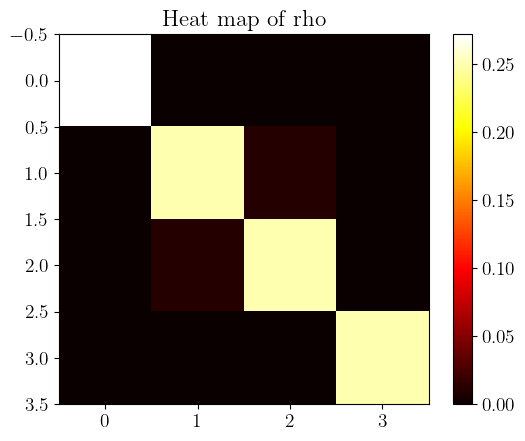

In [55]:
rho_ij=partial_ij_from_rho(rho, 3,7,N)
plt.imshow(abs(rho_ij), cmap='hot', interpolation='nearest')
plt.title("Heat map of rho")
plt.colorbar()
plt.show()

Density Matrix:
Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape = (4096, 4096), type = oper, isherm = True
Qobj data =
[[0.0446 0.     0.     0.0185 0.     0.     0.0261 0.     0.     0.
  ... 0.     0.     0.     0.     0.     0.     0.0185 0.     0.
  0.0185]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  ... 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  ... 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.0185 0.     0.     0.0076 0.     0.     0.0108 0.     0.     0.
  ... 0.     0.     0.     0.     0.     0.     0.0076 0.     0.
  0.0076]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  ... 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  ... 0.     0.     0.     0.     0.   

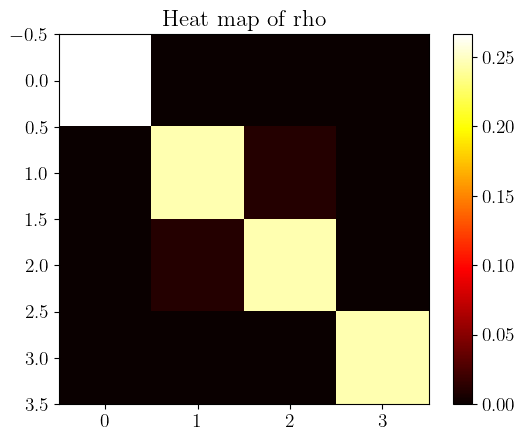

In [53]:
# Define basis states for 3 qubits
q0 = qt.basis(2, 0)  # |0⟩
q1 = qt.basis(2, 1)  # |1⟩
q00 = qt.tensor(q0, q0) # Example 3-qubit state: |0⟩ ⊗ |1⟩ ⊗ |1⟩
q11= qt.tensor(q1,q1)
bell=(q00+q11).unit()
bell1=qt.tensor(bell,bell,bell,bell,bell,bell)
bell2=qt.tensor(q0,bell,bell,bell,bell,bell,q0)
# Creating a density matrix from the state |0⟩ ⊗ |1⟩ ⊗ |1⟩
state=(bell1+bell2).unit()
rho = state * state.dag()
# Print the density matrix
print("Density Matrix:")
print(rho)

# Performing partial trace for the first qubit
rho_1 = qt.ptrace(rho, [0])
print("\nPartial Trace for the first qubit:")
print(rho_1)


# Performing partial trace for the second and third qubit
rho_23 = qt.ptrace(rho, [3, 7])
print("\nPartial Trace for the second and third qubit:")
print(rho_23)
rho_37=rho_23.full()

plt.imshow(abs(rho_37), cmap='hot', interpolation='nearest')
plt.title("Heat map of rho")
plt.colorbar()
plt.show()

[-3.1121e-02 -3.1037e-02  3.1196e-02 -3.0929e-02 -3.0792e-02  3.1028e-02
  3.0944e-02  3.0837e-02  3.0772e-02  3.0709e-02 ... -5.4654e-04
  1.8357e-04  1.4107e-04 -1.1564e-04 -3.8261e-04 -3.7712e-04 -7.5001e-04
 -4.3474e-05 -5.5253e-04 -3.8766e-04]
[ 0.0312  0.031   0.0309  0.0308  0.0308  0.0307  0.0306  0.0306  0.0305
  0.0305 ... -0.0304 -0.0305 -0.0306 -0.0306 -0.0307 -0.0307 -0.0308
 -0.0309 -0.031  -0.0311]


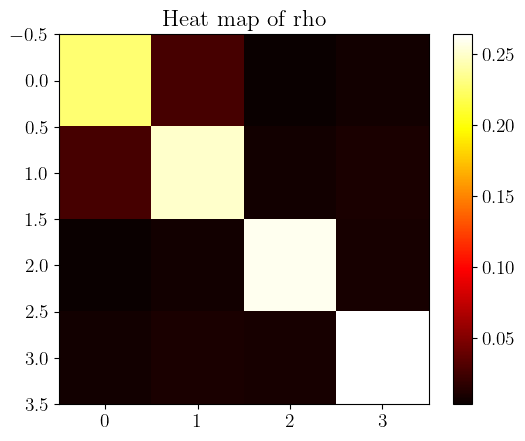

In [61]:
N=12
k=0

H = H_from_couplings(N, k)
eigenvalues, eigenvectors = np.linalg.eigh(H)
state = get_state(eigenvectors[0])
rho=get_full_density_matrix(state)

eigenvalues, eigenvectors = np.linalg.eig(H)
print(eigenvalues)    
#eigenvalues=abs(eigenvalues)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
print(eigenvalues)

rho_ij=partial_ij_from_rho(rho, 3,7,N)
plt.imshow(abs(rho_ij), cmap='hot', interpolation='nearest')
plt.title("Heat map of rho")
plt.colorbar()
plt.show()

In [58]:
rho_q=qt.Qobj(rho)
print(rho_q)
rho_ij_q=qt.ptrace(rho_q,[3,7])
rho_ij_full=rho_ij_q.full()
plt.imshow(abs(rho_ij), cmap='hot', interpolation='nearest')
plt.title("Heat map of rho")
plt.colorbar()
plt.show()

Quantum object: dims = [[4096], [4096]], shape = (4096, 4096), type = oper, isherm = True
Qobj data =
[[ 4.7122e-04 -5.8062e-04  3.7930e-04 -1.8186e-04  1.1883e-04 -3.1151e-04
   2.7350e-04 -2.2182e-04  2.5699e-04 -1.2310e-04 ...  9.7723e-05
  -7.3746e-04  1.1870e-03 -4.0668e-04  6.0213e-04 -1.2621e-03  1.4368e-04
  -9.4086e-04  9.0543e-05 -6.2645e-04]
 [-5.8062e-04  7.1543e-04 -4.6736e-04  2.2408e-04 -1.4641e-04  3.8383e-04
  -3.3700e-04  2.7332e-04 -3.1665e-04  1.5168e-04 ... -1.2041e-04
   9.0867e-04 -1.4626e-03  5.0109e-04 -7.4192e-04  1.5551e-03 -1.7703e-04
   1.1593e-03 -1.1156e-04  7.7189e-04]
 [ 3.7930e-04 -4.6736e-04  3.0531e-04 -1.4638e-04  9.5646e-05 -2.5074e-04
   2.2015e-04 -1.7855e-04  2.0685e-04 -9.9086e-05 ...  7.8660e-05
  -5.9360e-04  9.5548e-04 -3.2734e-04  4.8467e-04 -1.0159e-03  1.1565e-04
  -7.5732e-04  7.2880e-05 -5.0425e-04]
 [-1.8186e-04  2.2408e-04 -1.4638e-04  7.0185e-05 -4.5858e-05  1.2022e-04
  -1.0555e-04  8.5608e-05 -9.9179e-05  4.7508e-05 ... -3.7714e-05

IndexError: Invalid selection index in ptrace.

Defining MDS. We define a version that takes a Hamiltonian and a temperature for testing the thermal states, and we define a version that takes values N,k from which it can fetch couploing strengths and make a Hamiltonian from them.

In [40]:
def MDS_beta(H_given,N=12,beta=20,cuttoff=0.3):
    
    rho=expm(-beta*H_given)
    Tr=np.trace(rho)
    rho=rho/Tr
    plt.imshow(abs(rho), cmap='hot', interpolation='nearest')
    plt.title("Heat map of I")
    plt.colorbar()
    plt.show()

    I = get_I_matrix(N,rho)
    plt.imshow(I, cmap='hot', interpolation='nearest')
    plt.title("Heat map of I")
    plt.colorbar()
    plt.show()
    
    print("Graph of mutual information")
    define_graph(I)

    w=re_weighing(I)
    print("re-scaled graph of mutual information")
    define_graph(w)


    dab=distance(w)
    print("Graph of distances")
    define_graph(dab)

    Bab=calculate_B(dab)
    eig=get_eigenvalues(Bab)
    Xab=calculate_X(Bab)

    plt.imshow(Xab, cmap='hot', interpolation='nearest')
    plt.title("Heat map of the coordinate matrix")
    plt.colorbar()
    plt.show()

    plt.scatter(range(len(eig)),eig)
    plt.yscale('log')
    plt.ylabel(f'$\lambda_k$')
    plt.xlabel("k")
    plt.title("Scatter plot of eigenvalues")
    plt.show()
    #TODO define a function to get a D estimate from the cuttoff.
    
    stress_list=[]
    for d in range(1,N):
        stress_list.append(epsilon(d,eig))

    plt.scatter(range(1,N),stress_list)
    plt.title("Plot of the stress as a function of euclidean embedding dimension")
    plt.xlabel("D")
    plt.ylabel(f"$\epsilon$")
    plt.show()

    # we calculate the value of the stress for different chosen effective dimensions D

    D_eff=0
    for index, value in enumerate(stress_list):
        if value > cuttoff:
            D_eff= index+2

    print(f"Using cut-off:{cuttoff} we get D = {D_eff}")
    print(f"The stress for D = {D_eff} is : {epsilon(D_eff,eig)}")
    #From this we can creat an arbitrary condition on a dimension being appropriate. ie D = the first D such that stress<0.2?
    #In our case we woudl get D=5

    plot_3D_points(Xab)
    

def MDS_from_couplings(state_number,N=12,k=0,cuttoff=0.3):
    
    H = H_from_couplings(N, k)
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    state = get_state(eigenvectors[state_number])
    rho=get_full_density_matrix(state)
    
    I = get_I_matrix(N,rho)
    plt.imshow(I, cmap='hot', interpolation='nearest')
    plt.title("Heat map of I")
    plt.colorbar()
    plt.show()
    
    print("Graph of mutual information")
    define_graph(I)

    w=re_weighing(I)
    print("re-scaled graph of mutual information")
    define_graph(w)

    dab=distance(w)
    print("Graph of distances")
    define_graph(dab)

    Bab=calculate_B(dab)
    eig=get_eigenvalues(Bab)
    Xab=calculate_X(Bab)

    plt.imshow(Xab, cmap='hot', interpolation='nearest')
    plt.title("Heat map of the coordinate matrix")
    plt.colorbar()
    plt.show()

    plt.scatter(range(len(eig)),eig)
    plt.yscale('log')
    plt.ylabel(f'$\lambda_k$')
    plt.xlabel("k")
    plt.title("Scatter plot of eigenvalues")
    plt.show()
    
    stress_list=[]
    for d in range(1,N):
        stress_list.append(epsilon(d,eig))

    plt.scatter(range(1,N),stress_list)
    plt.title("Plot of the stress as a function of euclidean embedding dimension")
    plt.xlabel("D")
    plt.ylabel(f"$\epsilon$")
    plt.show()

    # we calculate the value of the stress for different chosen effective dimensions D

    D_eff=0
    for index, value in enumerate(stress_list):
        if value > cuttoff:
            D_eff= index+2

    print(f"Using cut-off:{cuttoff} we get D = {D_eff}")
    print(f"The stress for D = {D_eff} is : {epsilon(D_eff,eig)}")
    #From this we can creat an arbitrary condition on a dimension being appropriate. ie D = the first D such that stress<0.2?
    #In our case we woudl get D=5

    plot_3D_points(Xab)


def MDS_from_H_eig(H,state_number,N=12,cuttoff=0.3):
    
    #eigenvalues, eigenvectors = np.linalg.eigh(H)
    #state = get_state(eigenvectors[state_number])
    
    
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    if state_number==1000:
        minim=np.where(eigenvalues == eigenvalues.min())
    
        eigenvector_list=eigenvectors[minim]
        GS=eigenvector_list[0]
        for i in range(1,len(eigenvector_list)):
            GS+=eigenvector_list[i]
        state=GS/np.linalg.norm(GS)
    else: 
        state = get_state(eigenvectors[state_number])
    
    rho=get_full_density_matrix(state)
    
    I = get_I_matrix(N,rho)
    plt.imshow(I, cmap='hot', interpolation='nearest')
    plt.title("Heat map of I")
    plt.colorbar()
    plt.show()
    
    print("Graph of mutual information")
    define_graph(I)

    w=re_weighing(I)
    print("re-scaled graph of mutual information")
    define_graph(w)

    dab=distance(w)
    print("Graph of distances")
    define_graph(dab)

    Bab=calculate_B(dab)
    eig=get_eigenvalues(Bab)
    Xab=calculate_X(Bab)

    plt.imshow(Xab, cmap='hot', interpolation='nearest')
    plt.title("Heat map of the coordinate matrix")
    plt.colorbar()
    plt.show()

    plt.scatter(range(len(eig)),eig)
    plt.yscale('log')
    plt.ylabel(f'$\lambda_k$')
    plt.xlabel("k")
    plt.title("Scatter plot of eigenvalues")
    plt.show()
    
    stress_list=[]
    for d in range(1,N):
        stress_list.append(epsilon(d,eig))

    plt.scatter(range(1,N),stress_list)
    plt.title("Plot of the stress as a function of euclidean embedding dimension")
    plt.xlabel("D")
    plt.ylabel(f"$\epsilon$")
    plt.show()

    # we calculate the value of the stress for different chosen effective dimensions D

    D_eff=0
    for index, value in enumerate(stress_list):
        if value > cuttoff:
            D_eff= index+2

    print(f"Using cut-off:{cuttoff} we get D = {D_eff}")
    print(f"The stress for D = {D_eff} is : {epsilon(D_eff,eig)}")
    #From this we can creat an arbitrary condition on a dimension being appropriate. ie D = the first D such that stress<0.2?
    #In our case we woudl get D=5

    plot_3D_points(Xab)

def MDS_from_H_eig_with_correl(H,state_number,N=12,cuttoff=0.3):
    
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    minim=np.where(eigenvalues == eigenvalues.min())
    
    eigenvector_list=eigenvectors[minim]
    GS=eigenvector_list[0]
    for i in range(1,len(eigenvector_list)):
        GS+=eigenvector_list[i]
    state=GS/np.linalg.norm(GS)

    #state = get_state(eigenvectors[state_number])
    rho=get_full_density_matrix(state)
    
    I = get_correl_matrix(N,rho)
    plt.imshow(I, cmap='hot', interpolation='nearest')
    plt.title("Heat map of I")
    plt.colorbar()
    plt.show()
    
    print("Graph of mutual information")
    define_graph(I)

    w=re_weighing(I)
    print("re-scaled graph of mutual information")
    define_graph(w)

    dab=distance(w)
    print("Graph of distances")
    define_graph(dab)

    Bab=calculate_B(dab)
    eig=get_eigenvalues(Bab)
    Xab=calculate_X(Bab)

    plt.imshow(Xab, cmap='hot', interpolation='nearest')
    plt.title("Heat map of the coordinate matrix")
    plt.colorbar()
    plt.show()

    plt.scatter(range(len(eig)),eig)
    plt.yscale('log')
    plt.ylabel(f'$\lambda_k$')
    plt.xlabel("k")
    plt.title("Scatter plot of eigenvalues")
    plt.show()
    
    stress_list=[]
    for d in range(1,N):
        stress_list.append(epsilon(d,eig))

    plt.scatter(range(1,N),stress_list)
    plt.title("Plot of the stress as a function of euclidean embedding dimension")
    plt.xlabel("D")
    plt.ylabel(f"$\epsilon$")
    plt.show()

    # we calculate the value of the stress for different chosen effective dimensions D

    D_eff=0
    for index, value in enumerate(stress_list):
        if value > cuttoff:
            D_eff= index+2

    print(f"Using cut-off:{cuttoff} we get D = {D_eff}")
    print(f"The stress for D = {D_eff} is : {epsilon(D_eff,eig)}")
    #From this we can creat an arbitrary condition on a dimension being appropriate. ie D = the first D such that stress<0.2?
    #In our case we woudl get D=5

    plot_3D_points(Xab)

def MDS_from_state(state,N=12,cuttoff=0.3):
    
    #state = get_state(eigenvectors[state_number])
    rho=get_full_density_matrix(state)
    
    I = get_real_I_matrix(N,rho)
    plt.imshow(I, cmap='hot', interpolation='nearest')
    plt.title("Heat map of I")
    plt.colorbar()
    plt.show()
    
    print("Graph of mutual information")
    define_graph(I)

    w=re_weighing(I)
    print("re-scaled graph of mutual information")
    define_graph(w)

    dab=distance(w)
    print("Graph of distances")
    define_graph(dab)

    Bab=calculate_B(dab)
    eig=get_eigenvalues(Bab)
    Xab=calculate_X(Bab)

    plt.imshow(Xab, cmap='hot', interpolation='nearest')
    plt.title("Heat map of the coordinate matrix")
    plt.colorbar()
    plt.show()

    plt.scatter(range(len(eig)),eig)
    plt.yscale('log')
    plt.ylabel(f'$\lambda_k$')
    plt.xlabel("k")
    plt.title("Scatter plot of eigenvalues")
    plt.show()
    
    stress_list=[]
    for d in range(1,N):
        stress_list.append(epsilon(d,eig))

    plt.scatter(range(1,N),stress_list)
    plt.title("Plot of the stress as a function of euclidean embedding dimension")
    plt.xlabel("D")
    plt.ylabel(f"$\epsilon$")
    plt.show()

    # we calculate the value of the stress for different chosen effective dimensions D

    D_eff=0
    for index, value in enumerate(stress_list):
        if value > cuttoff:
            D_eff= index+2

    print(f"Using cut-off:{cuttoff} we get D = {D_eff}")
    print(f"The stress for D = {D_eff} is : {epsilon(D_eff,eig)}")
    #From this we can creat an arbitrary condition on a dimension being appropriate. ie D = the first D such that stress<0.2?
    #In our case we woudl get D=5

    plot_3D_points(Xab)


Where can I expect short range correlations? NOt in the Ising 1D S=1/2. In its theremal state though. In more compelx 1D models? In hand crafted states!


We test basic coupling of the pairs together with hadamr and CNOT and see if i get short range order like this.

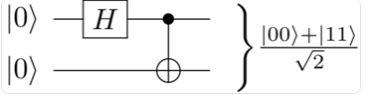

From the Bell state, I simpy string them together by kroneker product. 

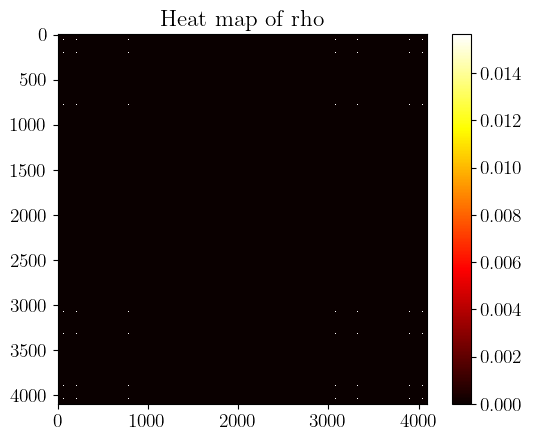

In [48]:

N=12
pauli_z=paulis[3]
pauli_y=paulis[2]
pauli_x=paulis[1]
id=np.identity(2)
Hadamar=1/np.sqrt(2)*ar([[1,1],[1,-1]])
CNOT=ar([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
zero_state=ar([1,0])
#state= [1] + [0] * (2**N-1)
state=zero_state
sup_state=Hadamar@zero_state
bell_state = CNOT@kr(sup_state,zero_state)
#for i in range(N):
#    state=state
#full_state=np.zeros((2**N,2**N), dtype=complex)
full_state_list=[bell_state]
for i in range(int(N/2)-1):
    temp=kr(full_state_list[-1],bell_state)
    full_state_list.append(temp)

state=full_state_list[-1]
rho=get_full_density_matrix(state)
plt.imshow(rho, cmap='hot', interpolation='nearest')
plt.title("Heat map of rho")
plt.colorbar()
plt.show()


In [ ]:

MDS_from_state(state,N)